In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='5'

In [2]:
import numpy as np
import json

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [4]:
from utils.drift_detection import *
from utils.model_utils import *
from utils.dataset_utils import *
from utils.stats import *

In [5]:
from timeit import default_timer as timer

# Create Office-31 DA Dataset

In [6]:
batch_size = 20

In [7]:
# labels = os.listdir('/local/rcs/wei/office31/amazon')
# with open("/local/rcs/wei/office31/label_dict.json", "w") as outfile:
#     json.dump({k: v for v, k in enumerate(labels)}, outfile)
with open("/local/rcs/wei/office31/label_dict.json", "r") as infile:
    label_dic = json.load(infile)

In [8]:
s_path = '/local/rcs/wei/office31/amazon'
t1_path = '/local/rcs/wei/office31/dslr'
t2_path = '/local/rcs/wei/office31/webcam'

In [9]:
datasets = read_datasets(s_path, t1_path, t2_path,label_dic)

/home/wei.hao/drift-detection/utils/dataset_utils.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), np.array(Y)


In [10]:
data_transforms = {
            'train': transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize([256, 256]),
                transforms.RandomCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'test': transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize([224, 224]),
                transforms.CenterCrop((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
}

In [11]:
s_loader, s_size = create_dataloader(datasets['source'],data_transforms, batch_size, num_ref_per_class = 30) #amazon30, dslr10, webcam20 

/home/wei.hao/drift-detection/utils/dataset_utils.py:146: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X_ref), np.array(Y_ref), np.array(X_test), np.array(Y_test)


# Create Model

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.classifier[1] = nn.Linear(num_ftrs, 31)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
model = model.to(device)

In [14]:
# model = train_model(model, s_loader, s_size, criterion, optimizer_ft, exp_lr_scheduler,30, device)

In [15]:
model.load_state_dict(torch.load('./models/amazon_new.pt'))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [16]:
torch.cuda.empty_cache()
eval_model(model, s_loader['val'],device)

val Acc: 0.816110


tensor(0.8161, dtype=torch.float64)

# Drift Detection

In [17]:
def compute_logits(model, device, s_loader):
	"""
	Compute logits (to be given as input to drift detector)
	"""

	flag = True
	ref_logist = 0
	for inputs, labels in s_loader:
	    inputs = inputs.to(device)
	    with torch.no_grad():
	        outputs = model(inputs).cpu()
	    torch.cuda.empty_cache()
	    if flag:
	        ref_logist = outputs
	        flag = False
	    else:
	        ref_logist = torch.cat((ref_logist,outputs), 0)

	return ref_logist

In [18]:
# calclulate the ref_logists
ref_logist = compute_logits(model, device, s_loader['val'])

In [19]:
drift_detector = drift_detection(ref_logist, 0.05, method="KSDrift")

In [20]:
t1_loader, t1_size = create_dataloader(datasets['target1'],data_transforms, source = False, batch_size = batch_size)
t2_loader, t2_size = create_dataloader(datasets['target2'],data_transforms, source = False, batch_size = batch_size)

In [21]:
torch.cuda.empty_cache()
eval_model(model, t1_loader['val'],device)

val Acc: 0.528112


tensor(0.5281, dtype=torch.float64)

In [22]:
torch.cuda.empty_cache()
eval_model(model, t2_loader['val'],device)

val Acc: 0.504403


tensor(0.5044, dtype=torch.float64)

In [23]:
accs, drift_pos, uncertainties, times, start = drift_statistics(t2_loader['val'], model, drift_detector, device)

In [24]:
# calclulate the ref_logists
test_logist = compute_logits(model, device, t1_loader['val'])

In [25]:
result = drift_detector.get_result(test_logist)

In [26]:
print('Uncertainty - Max: {:.4f} | Min: {:.4f} | Mean: {:.4f} | Std: {:.4f}'.format(np.max(uncertainties), np.min(uncertainties), np.mean(uncertainties), np.std(uncertainties)))
print('ks statistics: {} | p-value: {}'.format(result['distance'],result['p_val']))

Uncertainty - Max: 2.8252 | Min: 0.0000 | Mean: 0.9691 | Std: 0.7157
ks statistics: 0.3997356676307775 | p-value: 2.5201839383157097e-57


# Mix 3 datasets together

In [27]:
batch_size = 64

In [28]:
full_loader, full_size = mixed_dataloader(datasets, data_transforms, shuffle = False, batch_size = batch_size)

In [29]:
torch.cuda.empty_cache()
eval_model(model, full_loader['val'],device)

val Acc: 0.693082


tensor(0.6931, dtype=torch.float64)

In [30]:
accs, drift_pos, uncertainties, times, start = drift_statistics(full_loader['val'], model, drift_detector, device)

In [31]:
threshold = 0.816110 - 0.1

In [32]:
t_p, f_p, f_n,t_n = confusion_matrix(accs, drift_pos, threshold)

In [33]:
print('Total-Sample: {:.0f} | Batchsize: {} | True-Postive: {:.2f} | False-Postive: {:.2f} | False-Negative: {:.2f} | True-Negative: {:.2f}'.format(full_size['val'],batch_size ,t_p/(full_size['val']/batch_size), f_p/(full_size['val']/batch_size), f_n/(full_size['val']/batch_size),t_n/(full_size['val']/batch_size)))

Total-Sample: 3180 | Batchsize: 64 | True-Postive: 0.42 | False-Postive: 0.36 | False-Negative: 0.00 | True-Negative: 0.22


# Plot

In [34]:
import matplotlib.pyplot as plt

Total-Sample: 3180 | Batchsize: 64 | True-Postive: 0.42 | False-Postive: 0.36 | False-Negative: 0.00 | True-Negative: 0.22


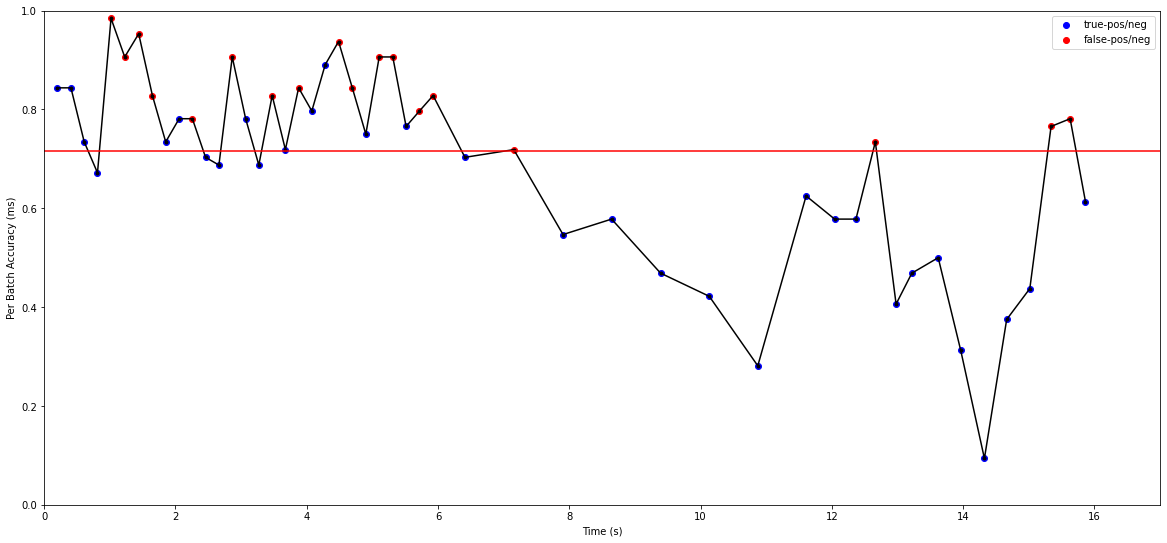

In [35]:
times_ = np.asarray(times) - start
accs = np.asarray(accs)

# find out which parameters are more than 1.5*std away from mean
thresholded = [1 if accs[i] < threshold else 0 for i in range(0,len(accs))]
correct =  np.asarray([i for i in range(0,len(accs)) if thresholded[i] == drift_pos[i]])
wrong =  np.asarray([i for i in range(0,len(accs)) if thresholded[i] != drift_pos[i]])

# enable drawing of multiple graphs on one plot
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(211)
ax.axis(ymin=0.,ymax=1.)
ax.axis(xmin=0.,xmax=17.)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Per Batch Accuracy (ms)')

# draw some lines behind the scatter plots (using zorder)
ax.plot(times_, accs, marker='.', color='black')


# scatter valid (not warning) points in blue (c='b')
ax.scatter(times_[correct], accs[correct], label='true-pos/neg', c='b')

# scatter warning points in red (c='r')
ax.scatter(times_[wrong], accs[wrong], label='false-pos/neg', c='r')

plt.axhline(y=threshold, color='r', linestyle='-')

# draw the legend
ax.legend()

# show the figure
print('Total-Sample: {:.0f} | Batchsize: {} | True-Postive: {:.2f} | False-Postive: {:.2f} | False-Negative: {:.2f} | True-Negative: {:.2f}'.format(full_size['val'],batch_size ,t_p/(full_size['val']/batch_size), f_p/(full_size['val']/batch_size), f_n/(full_size['val']/batch_size),t_n/(full_size['val']/batch_size)))